# Deutsch-Jozsa Algorithm

**Course**: Quantum Computing Laboratory  
**Version**: 2.2 (Qiskit 2.2 Compatible)  
**Last Updated**: November 2025

---

## Table of Contents

1. [Theory and Background](#theory)
2. [Learning Objectives](#objectives)
3. [Prerequisites](#prerequisites)
4. [Mathematical Foundation](#math)
5. [Implementation](#implementation)
   - [Setup and Imports](#setup)
   - [Oracle Construction](#oracle)
   - [Deutsch-Jozsa Circuit](#circuit)
   - [Local Simulation](#simulation)
   - [IBM Quantum Hardware Execution](#hardware)
6. [Results Analysis](#results)
7. [Complexity Comparison](#complexity)
8. [Exercises](#exercises)
9. [References](#references)

## 📚 Theory and Background

The **Deutsch-Jozsa algorithm** was one of the first quantum algorithms to demonstrate a quantum advantage over classical computation. Proposed by David Deutsch and Richard Jozsa in 1992, it solves a specific problem **exponentially faster** than any deterministic classical algorithm.

### Problem Statement

Given a function $f: \{0,1\}^n \rightarrow \{0,1\}$ that is **promised** to be either:
- **Constant**: $f(x) = c$ for all $x$ (where $c \in \{0,1\}$)
- **Balanced**: $f(x) = 0$ for exactly half the inputs and $f(x) = 1$ for the other half

**Goal**: Determine whether $f$ is constant or balanced.

### Classical Complexity

- **Deterministic Classical Algorithm**: Must check $2^{n-1} + 1$ inputs in worst case
- **Randomized Classical Algorithm**: Requires $O(2^n)$ queries with high probability

### Quantum Advantage

The Deutsch-Jozsa algorithm solves this problem with:
- **Exactly 1 query** to the oracle
- **100% accuracy** (deterministic)
- **Exponential speedup**: $O(1)$ vs $O(2^n)$

This is one of the clearest examples of quantum parallelism through superposition!

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. ✅ Understand the Deutsch-Jozsa problem and its significance
2. ✅ Implement quantum oracles for constant and balanced functions
3. ✅ Build the complete Deutsch-Jozsa circuit from scratch
4. ✅ Simulate the algorithm locally using Qiskit Aer
5. ✅ Execute the algorithm on real IBM Quantum hardware
6. ✅ Analyze and interpret quantum measurement results
7. ✅ Compare simulation vs hardware performance
8. ✅ Understand quantum superposition and interference in practice

## 🔧 Prerequisites

**Required Knowledge:**
- Basic quantum gates (Hadamard, CNOT, X, Z)
- Quantum superposition concept
- Binary representation and Boolean functions
- Basic linear algebra (vectors, matrices)

**Required Software:**
- Python 3.9 or higher
- Qiskit 2.2 or higher
- IBM Quantum account (for hardware execution)

**Recommended Previous Notebooks:**
- `construct-circuits.ipynb`
- `operators.ipynb`
- `measurement.ipynb`

## 📐 Mathematical Foundation

### Circuit Structure

The Deutsch-Jozsa algorithm consists of four main steps:

1. **Initialization**: Prepare input qubits in $|0\rangle$ and ancilla in $|1\rangle$
   $$|\psi_0\rangle = |0\rangle^{\otimes n} |1\rangle$$

2. **Superposition**: Apply Hadamard gates to all qubits
   $$|\psi_1\rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n-1} |x\rangle (|0\rangle - |1\rangle)$$

3. **Oracle Query**: Apply the quantum oracle $U_f$
   $$|\psi_2\rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle (|0\rangle - |1\rangle)$$

4. **Interference**: Apply Hadamard gates to input qubits
   $$|\psi_3\rangle = \sum_{z=0}^{2^n-1} \left[\frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x) + x \cdot z}\right] |z\rangle$$

### Key Insight

After measurement:
- If $f$ is **constant**: Measure $|00...0\rangle$ with probability 1
- If $f$ is **balanced**: Measure any state **except** $|00...0\rangle$

This works because:
- **Constant function**: All amplitudes interfere constructively at $|0\rangle^{\otimes n}$
- **Balanced function**: Amplitudes interfere destructively at $|0\rangle^{\otimes n}$

## 💻 Implementation

Now let's implement the Deutsch-Jozsa algorithm in Qiskit 2.2!

### Step 1: Setup and Imports

We'll use Qiskit 2.2's unified package structure with modern primitives.

In [2]:
# Core Qiskit imports (Qiskit 2.2)
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Qiskit Aer for local simulation
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# IBM Quantum Runtime for hardware execution
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as IBMSampler

# Utilities
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
import time

print("✓ All imports successful!")
print(f"  Qiskit components loaded")
print(f"  Ready to build quantum circuits")

✓ All imports successful!
  Qiskit components loaded
  Ready to build quantum circuits


### Step 2: Oracle Construction

The oracle $U_f$ implements the function $f$ as a quantum gate. It performs the transformation:
$$U_f |x\rangle |y\rangle = |x\rangle |y \oplus f(x)\rangle$$

We'll implement four types of oracles to test the algorithm:
1. **Balanced Oracle 1**: $f(x) = x_0$ (outputs first qubit)
2. **Balanced Oracle 2**: $f(x) = x_0 \oplus x_1$ (XOR of first two qubits)
3. **Constant Oracle 1**: $f(x) = 0$ (always outputs 0)
4. **Constant Oracle 2**: $f(x) = 1$ (always outputs 1)

In [3]:
def create_oracle(n_qubits: int, oracle_type: str) -> QuantumCircuit:
    """
    Create a quantum oracle for the Deutsch-Jozsa algorithm.
    
    Args:
        n_qubits: Number of input qubits
        oracle_type: Type of oracle to create
            - 'balanced_1': f(x) = x_0 (first qubit)
            - 'balanced_2': f(x) = x_0 XOR x_1 (XOR of first two qubits)
            - 'constant_0': f(x) = 0 (always zero)
            - 'constant_1': f(x) = 1 (always one)
    
    Returns:
        QuantumCircuit: Oracle circuit implementing f(x)
    """
    # Create circuit with n input qubits + 1 ancilla qubit
    oracle = QuantumCircuit(n_qubits + 1, name=f"Oracle_{oracle_type}")
    
    if oracle_type == 'balanced_1':
        # f(x) = x_0: Copy first qubit to ancilla
        # Uses CNOT: if q0=1, flip ancilla
        oracle.cx(0, n_qubits)
        
    elif oracle_type == 'balanced_2':
        # f(x) = x_0 XOR x_1: XOR first two qubits
        # Apply CNOT from both q0 and q1 to ancilla
        oracle.cx(0, n_qubits)
        oracle.cx(1, n_qubits)
        
    elif oracle_type == 'constant_0':
        # f(x) = 0: Do nothing (identity)
        # No gates needed - oracle doesn't flip ancilla
        pass
        
    elif oracle_type == 'constant_1':
        # f(x) = 1: Always flip ancilla
        # Apply X gate to ancilla (independent of input)
        oracle.x(n_qubits)
        
    else:
        raise ValueError(f"Unknown oracle type: {oracle_type}")
    
    return oracle

Oracle Examples (for n=3 qubits):

balanced_1      - Gates:  1, Depth: 1
balanced_2      - Gates:  2, Depth: 2
constant_0      - Gates:  0, Depth: 0
constant_1      - Gates:  1, Depth: 1

Example: Constant Oracle 1


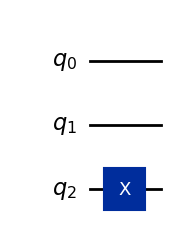

In [4]:
# Test: Create and visualize each oracle type
n = 2  # Number of input qubits
oracle_types = ['balanced_1', 'balanced_2', 'constant_0', 'constant_1']

print("Oracle Examples (for n=3 qubits):\n")
for otype in oracle_types:
    oracle = create_oracle(n, otype)
    print(f"{otype:15s} - Gates: {oracle.size():2d}, Depth: {oracle.depth()}")

# Visualize one example
print("\n" + "="*50)
print("Example: Constant Oracle 1")
print("="*50)
create_oracle(n, 'constant_1').draw('mpl', fold=-1)

### Step 3: Complete Deutsch-Jozsa Circuit

Now we build the complete algorithm with all four steps:
1. Initialize qubits
2. Apply Hadamard gates (create superposition)
3. Apply oracle
4. Apply Hadamard gates again (create interference)
5. Measure input qubits

In [5]:
def deutsch_jozsa_circuit(n_qubits: int, oracle_type: str) -> QuantumCircuit:
    """
    Build complete Deutsch-Jozsa circuit.
    
    Args:
        n_qubits: Number of input qubits
        oracle_type: Type of oracle ('balanced_1', 'balanced_2', 'constant_0', 'constant_1')
    
    Returns:
        QuantumCircuit: Complete Deutsch-Jozsa circuit with measurements
    """
    # Create quantum and classical registers
    # n input qubits + 1 ancilla qubit
    qr = QuantumRegister(n_qubits, 'input')
    ancilla = QuantumRegister(1, 'ancilla')
    cr = ClassicalRegister(n_qubits, 'output')
    
    circuit = QuantumCircuit(qr, ancilla, cr)
    
    # STEP 1: Initialize ancilla to |1⟩
    # Input qubits start in |0⟩ by default
    circuit.x(ancilla)
    circuit.barrier(label='Init')
    
    # STEP 2: Apply Hadamard to all qubits (create superposition)
    # Input qubits: |0⟩ → |+⟩ (equal superposition)
    # Ancilla: |1⟩ → |−⟩ (enables phase kickback)
    circuit.h(qr)
    circuit.h(ancilla)
    circuit.barrier(label='Superposition')
    
    # STEP 3: Apply Oracle
    # Query the function f(x) in superposition
    oracle = create_oracle(n_qubits, oracle_type)
    circuit.compose(oracle, inplace=True)
    circuit.barrier(label='Oracle')
    
    # STEP 4: Apply Hadamard to input qubits (create interference)
    # This causes constructive/destructive interference
    # Constant: constructive at |00...0⟩
    # Balanced: destructive at |00...0⟩
    circuit.h(qr)
    circuit.barrier(label='Interference')
    
    # STEP 5: Measure input qubits only
    # We don't measure the ancilla
    circuit.measure(qr, cr)
    
    return circuit

Building Deutsch-Jozsa Circuits...

balanced_1      - Total qubits: 21, Depth: 5, Gates: 63
balanced_2      - Total qubits: 21, Depth: 6, Gates: 64
constant_0      - Total qubits: 21, Depth: 4, Gates: 62
constant_1      - Total qubits: 21, Depth: 5, Gates: 63

Complete Deutsch-Jozsa Circuit (Balanced Oracle 1)


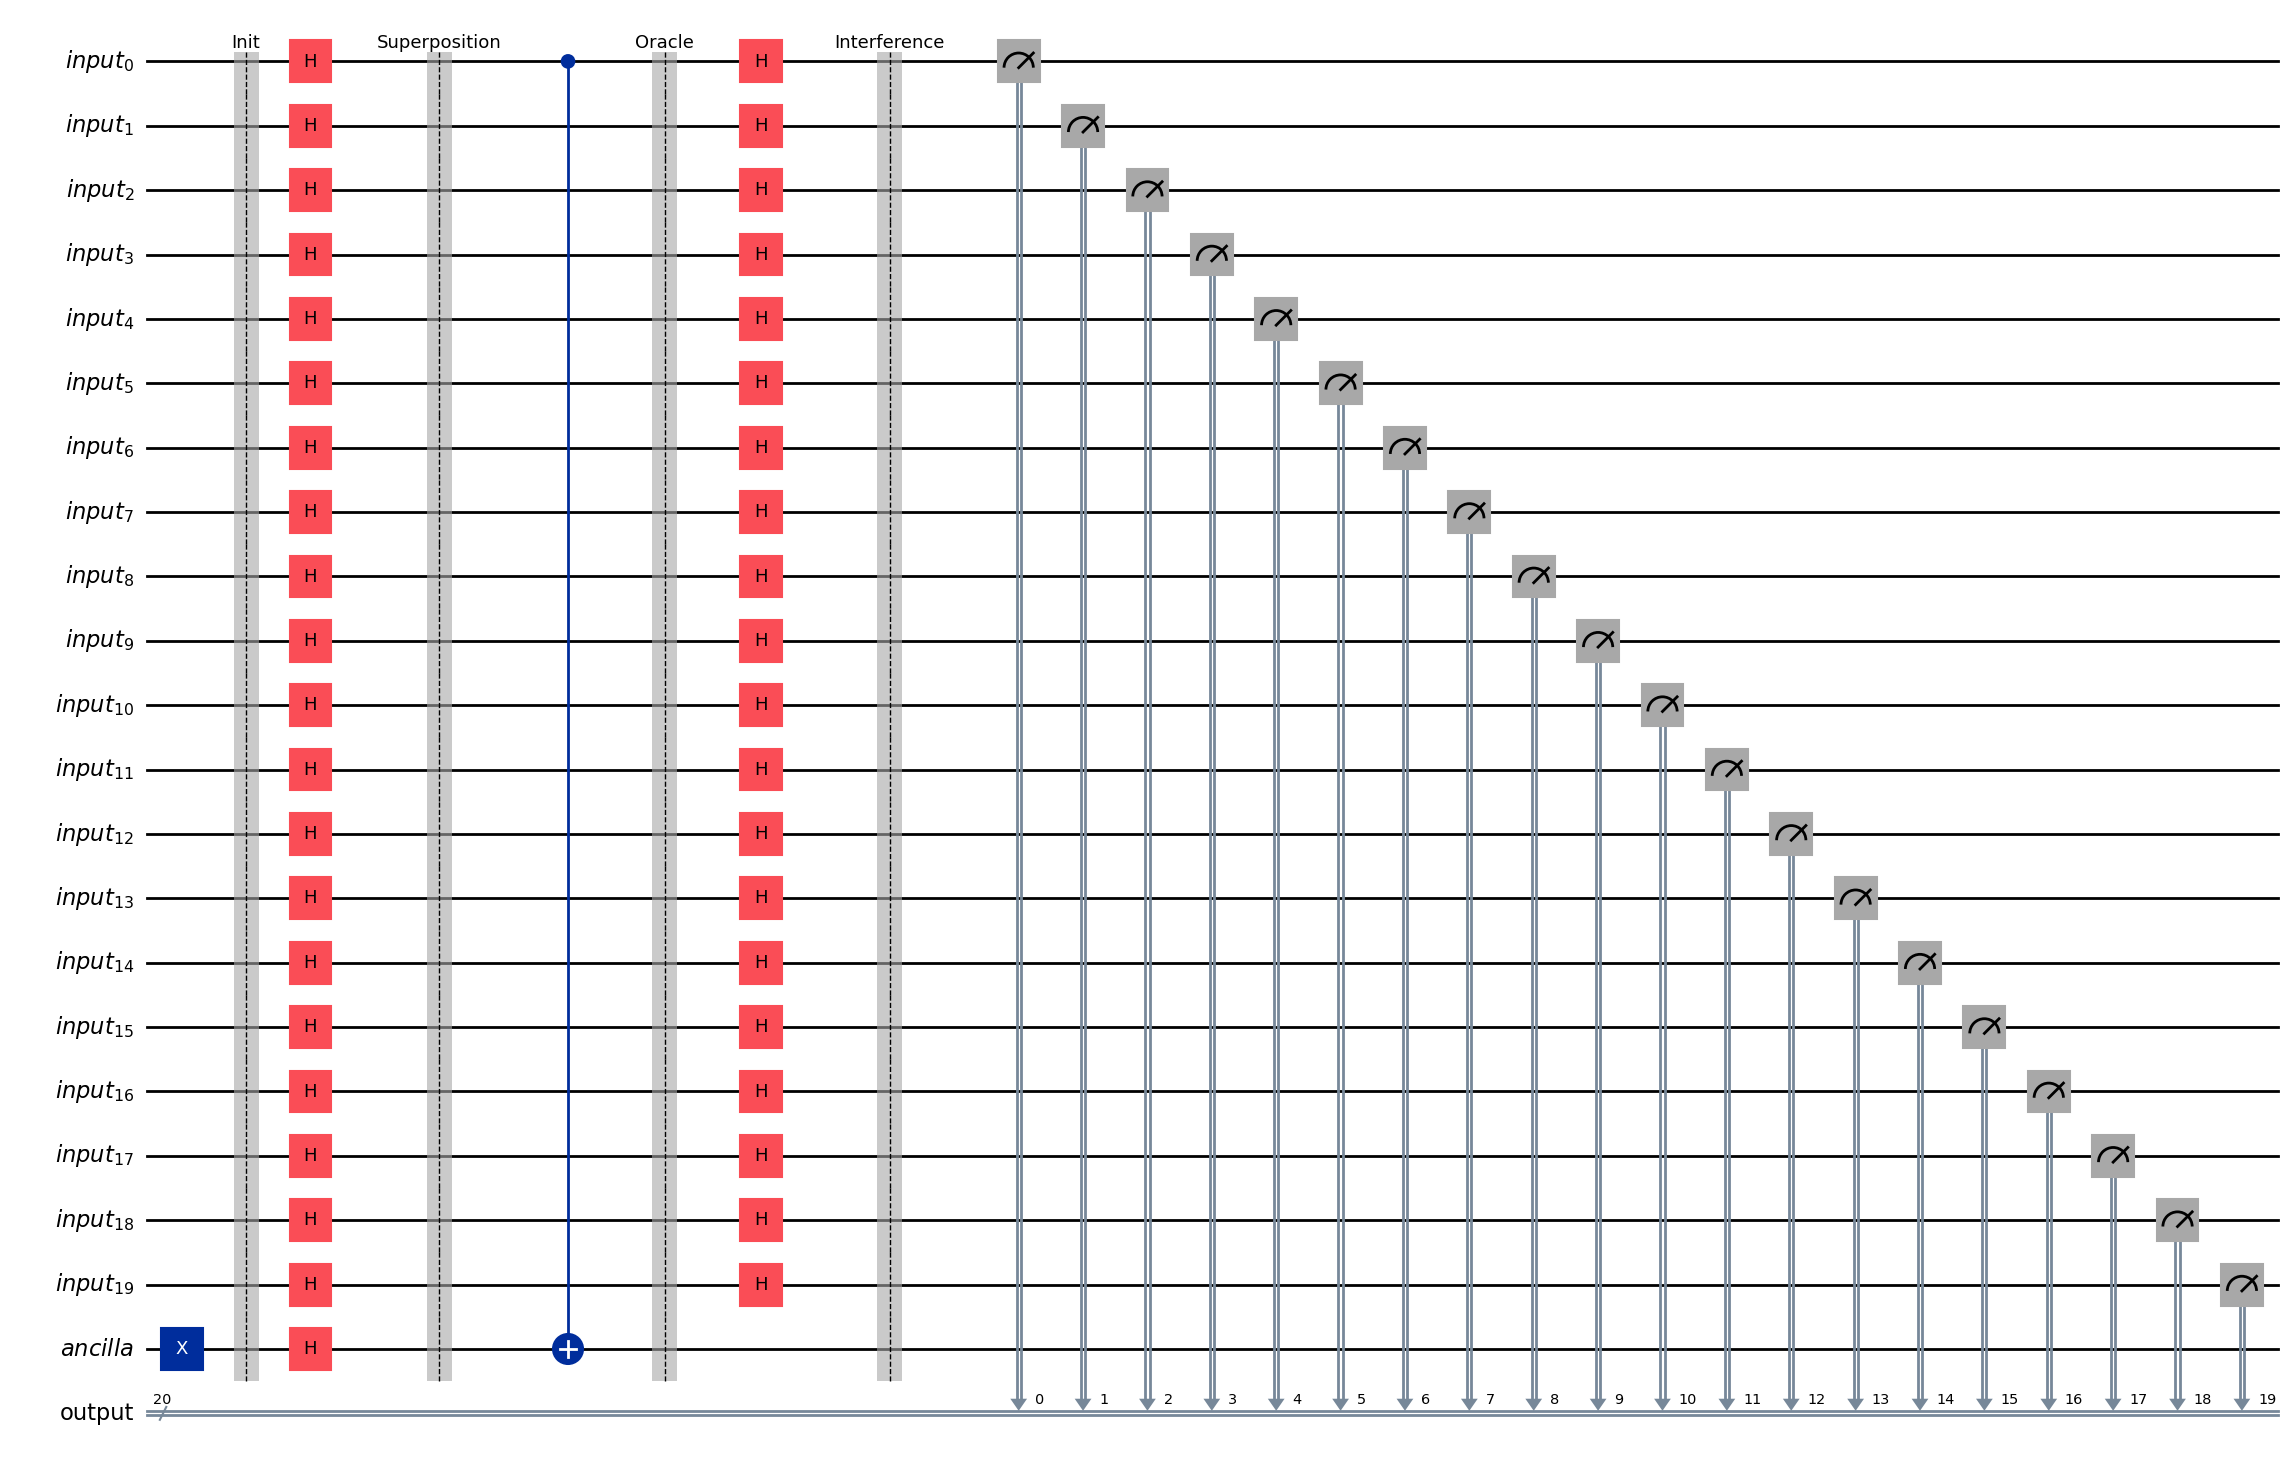

In [23]:
# Build circuits for all oracle types
print("Building Deutsch-Jozsa Circuits...\n")

n = 20 # Use 3 input qubits for examples
circuits = {}

for otype in oracle_types:
    circuits[otype] = deutsch_jozsa_circuit(n, otype)
    print(f"{otype:15s} - Total qubits: {circuits[otype].num_qubits}, "
          f"Depth: {circuits[otype].depth()}, Gates: {circuits[otype].size()}")

# Visualize one complete circuit
print("\n" + "="*70)
print("Complete Deutsch-Jozsa Circuit (Balanced Oracle 1)")
print("="*70)
circuits['balanced_1'].draw('mpl', fold=-1)

### Step 4: Local Simulation

Before running on hardware, let's test with Aer simulator to verify our implementation.

In [24]:
def run_simulation(circuit: QuantumCircuit, shots: int = 1024) -> Dict:
    """
    Run circuit on local Aer simulator using SamplerV2.
    
    Args:
        circuit: Quantum circuit to execute
        shots: Number of measurement shots
    
    Returns:
        Dict: Measurement counts
    """
    # Create Aer simulator
    simulator = AerSimulator()
    
    # Use SamplerV2 primitive (Qiskit 2.2 style)
    sampler = AerSampler()
    
    # Transpile circuit for simulator
    pm = generate_preset_pass_manager(optimization_level=1, backend=simulator)
    transpiled = pm.run(circuit)
    
    # Run simulation
    job = sampler.run([transpiled], shots=shots)
    result = job.result()
    
    # Extract counts from PubResult
    pub_result = result[0]
    counts = pub_result.data.output.get_counts()
    
    return counts


# Run simulations for all oracle types
print("Running Simulations...\n")
print("="*70)

sim_results = {}
for otype in oracle_types:
    print(f"\nOracle: {otype}")
    print("-" * 40)
    
    counts = run_simulation(circuits[otype], shots=1024)
    sim_results[otype] = counts
    
    # Interpret result
    all_zeros = '0' * n
    if all_zeros in counts and counts[all_zeros] > 900:
        interpretation = "CONSTANT function"
    else:
        interpretation = "BALANCED function"
    
    print(f"  Result: {interpretation}")
    print(f"  Measurements: {counts}")
    
    # Expected result
    expected = "CONSTANT" if 'constant' in otype else "BALANCED"
    status = "✓" if expected in interpretation else "✗"
    print(f"  Expected: {expected} {status}")

print("\n" + "="*70)

Running Simulations...


Oracle: balanced_1
----------------------------------------
  Result: BALANCED function
  Measurements: {'00000000000000000001': 1024}
  Expected: BALANCED ✓

Oracle: balanced_2
----------------------------------------
  Result: BALANCED function
  Measurements: {'00000000000000000011': 1024}
  Expected: BALANCED ✓

Oracle: constant_0
----------------------------------------
  Result: CONSTANT function
  Measurements: {'00000000000000000000': 1024}
  Expected: CONSTANT ✓

Oracle: constant_1
----------------------------------------
  Result: CONSTANT function
  Measurements: {'00000000000000000000': 1024}
  Expected: CONSTANT ✓



### Visualization of Simulation Results

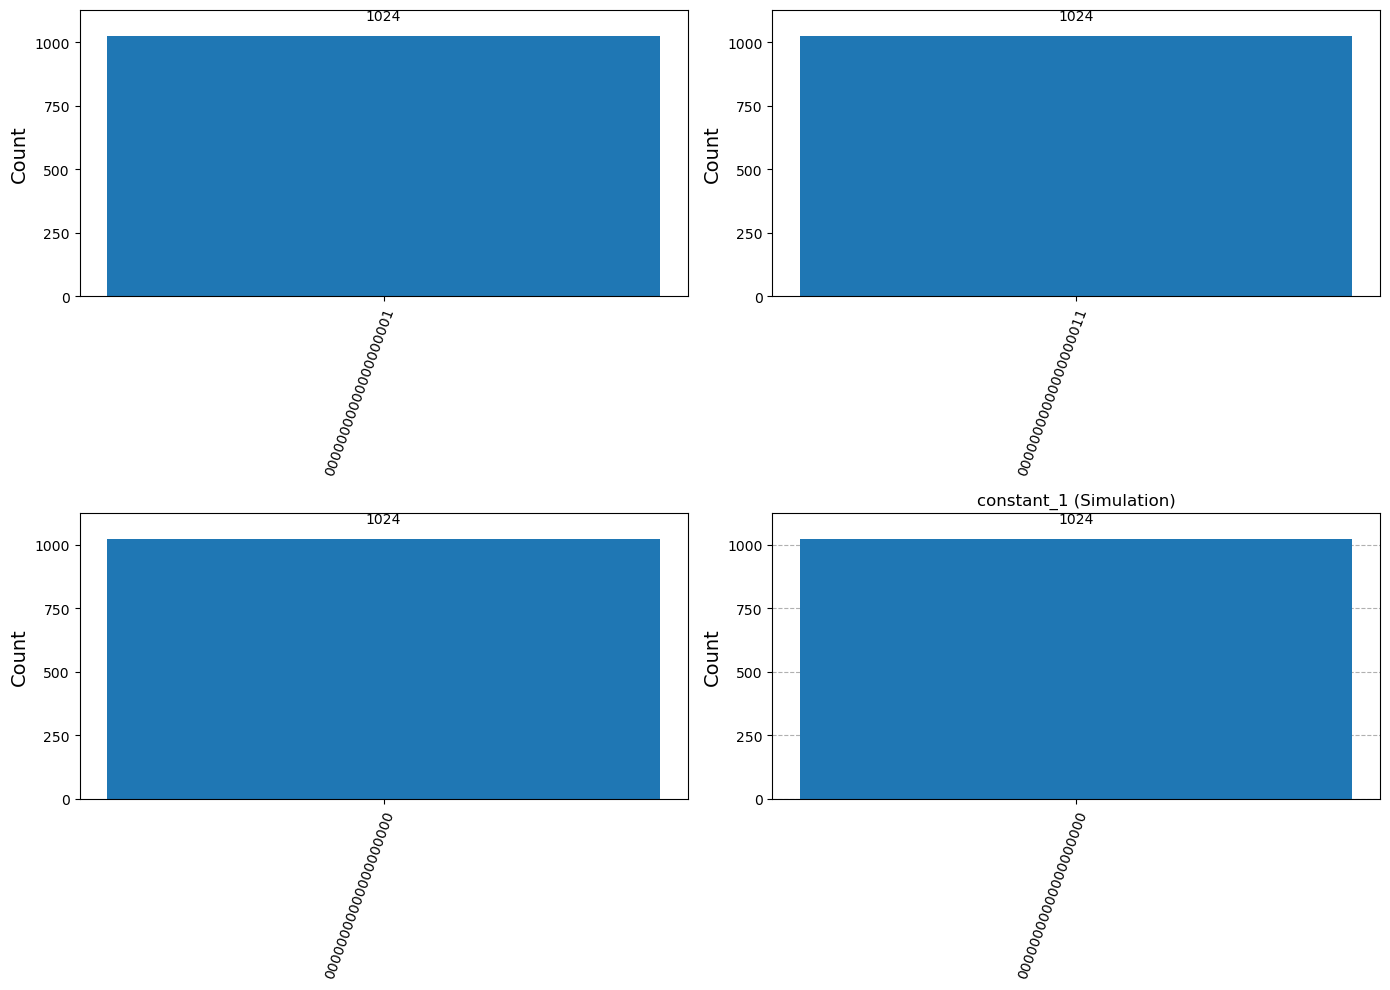


📊 Observations:
  • Constant functions: Measure |000⟩ with ~100% probability
  • Balanced functions: Measure any state EXCEPT |000⟩
  • Perfect results expected in simulation (no noise)


In [25]:
# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, otype in enumerate(oracle_types):
    plot_histogram(sim_results[otype], ax=axes[idx], 
                   title=f"{otype} (Simulation)")

plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("  • Constant functions: Measure |000⟩ with ~100% probability")
print("  • Balanced functions: Measure any state EXCEPT |000⟩")
print("  • Perfect results expected in simulation (no noise)")

### Step 5: IBM Quantum Hardware Execution

Now let's run on real quantum hardware! This demonstrates quantum computing in practice.

#### 5.1 IBM Quantum Account Setup

First-time users need to save their IBM Quantum credentials.

In [26]:
# FIRST TIME ONLY: Save your IBM Quantum account
# Uncomment and run this cell once with your token

from qiskit_ibm_runtime import QiskitRuntimeService
#

QiskitRuntimeService.save_account(
  token="", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
  name="Roberto Cappuccio", # Optional
  instance="open-instance", # Optional
  set_as_default=True, # Optional
  overwrite=True, # Optional
)

print("✓ Account saved successfully!")

# Get your token from: https://quantum.ibm.com/account

InvalidAccountError: "Invalid `token` value. Expected a non-empty string, got ''."

In [27]:
service = QiskitRuntimeService()

In [11]:
# Load IBM Quantum service (run every session)
try:
    service = QiskitRuntimeService()
    print("✓ IBM Quantum service loaded successfully!")
    print(f"  Channel: {service.channel}")
except Exception as e:
    print(f"⚠ Error loading service: {e}")
    print("  Please save your account first using the cell above.")

✓ IBM Quantum service loaded successfully!
  Channel: ibm_quantum_platform


#### 5.2 Backend Selection

Choose an appropriate quantum backend based on:
- Number of qubits needed
- Queue length
- Quantum volume
- Error rates

In [28]:
# List available quantum backends
print("Available IBM Quantum Backends:\n")
print("="*80)

backends = service.backends(
    simulator=False,
    operational=True,
    min_num_qubits=156  # Need at least 4 qubits (3 input + 1 ancilla)
)

backend_info = []
for backend in backends:
    status = backend.status()
    config = backend.configuration()
    
    info = {
        'name': backend.name,
        'qubits': config.n_qubits,
        'pending_jobs': status.pending_jobs,
        'operational': status.operational,
        'status_msg': status.status_msg
    }
    backend_info.append(info)
    
    print(f"Backend: {info['name']}")
    print(f"  Qubits: {info['qubits']}")
    print(f"  Queue: {info['pending_jobs']} jobs")
    print(f"  Status: {info['status_msg']}")
    print("-" * 80)

if not backends:
    print("⚠ No backends available. You may need to:")
    print("  1. Join the IBM Quantum Network")
    print("  2. Wait for backends to become operational")
    print("  3. Check your account access level")

Available IBM Quantum Backends:

Backend: ibm_fez
  Qubits: 156
  Queue: 0 jobs
  Status: active
--------------------------------------------------------------------------------
Backend: ibm_marrakesh
  Qubits: 156
  Queue: 19866 jobs
  Status: active
--------------------------------------------------------------------------------


In [29]:
# Select the least busy backend
try:
    backend = service.least_busy(
        operational=True,
        simulator=False,
        min_num_qubits=4
    )
    
    print(f"✓ Selected backend: {backend.name}")
    print(f"  Qubits: {backend.configuration().n_qubits}")
    print(f"  Pending jobs: {backend.status().pending_jobs}")
    
    # Get backend properties
    props = backend.properties()
    if props:
        # Average T1 and T2 times
        t1_avg = np.mean([props.t1(i) for i in range(backend.configuration().n_qubits)])
        t2_avg = np.mean([props.t2(i) for i in range(backend.configuration().n_qubits)])
        print(f"  Avg T1: {t1_avg*1e6:.1f} μs")
        print(f"  Avg T2: {t2_avg*1e6:.1f} μs")
    
except Exception as e:
    print(f"⚠ Could not select backend: {e}")
    print("  Continuing with simulation only.")
    backend = None

✓ Selected backend: ibm_fez
  Qubits: 156
  Pending jobs: 0
  Avg T1: 139.5 μs
  Avg T2: 103.0 μs


#### 5.3 Circuit Transpilation

Transpile our circuit to match the hardware's native gate set and topology.

Transpiling circuit for ibm_fez...

Circuit Comparison:
Metric                           Original      Transpiled
------------------------------------------------------------
Qubits                                 21             156
Depth                                   5              14
Gate count                             63             150
2-qubit gates                           1               1

Transpiled gate distribution:
  barrier: 4
  cz: 1
  measure: 20
  rz: 85
  sx: 43
  x: 1

Transpiled Circuit:


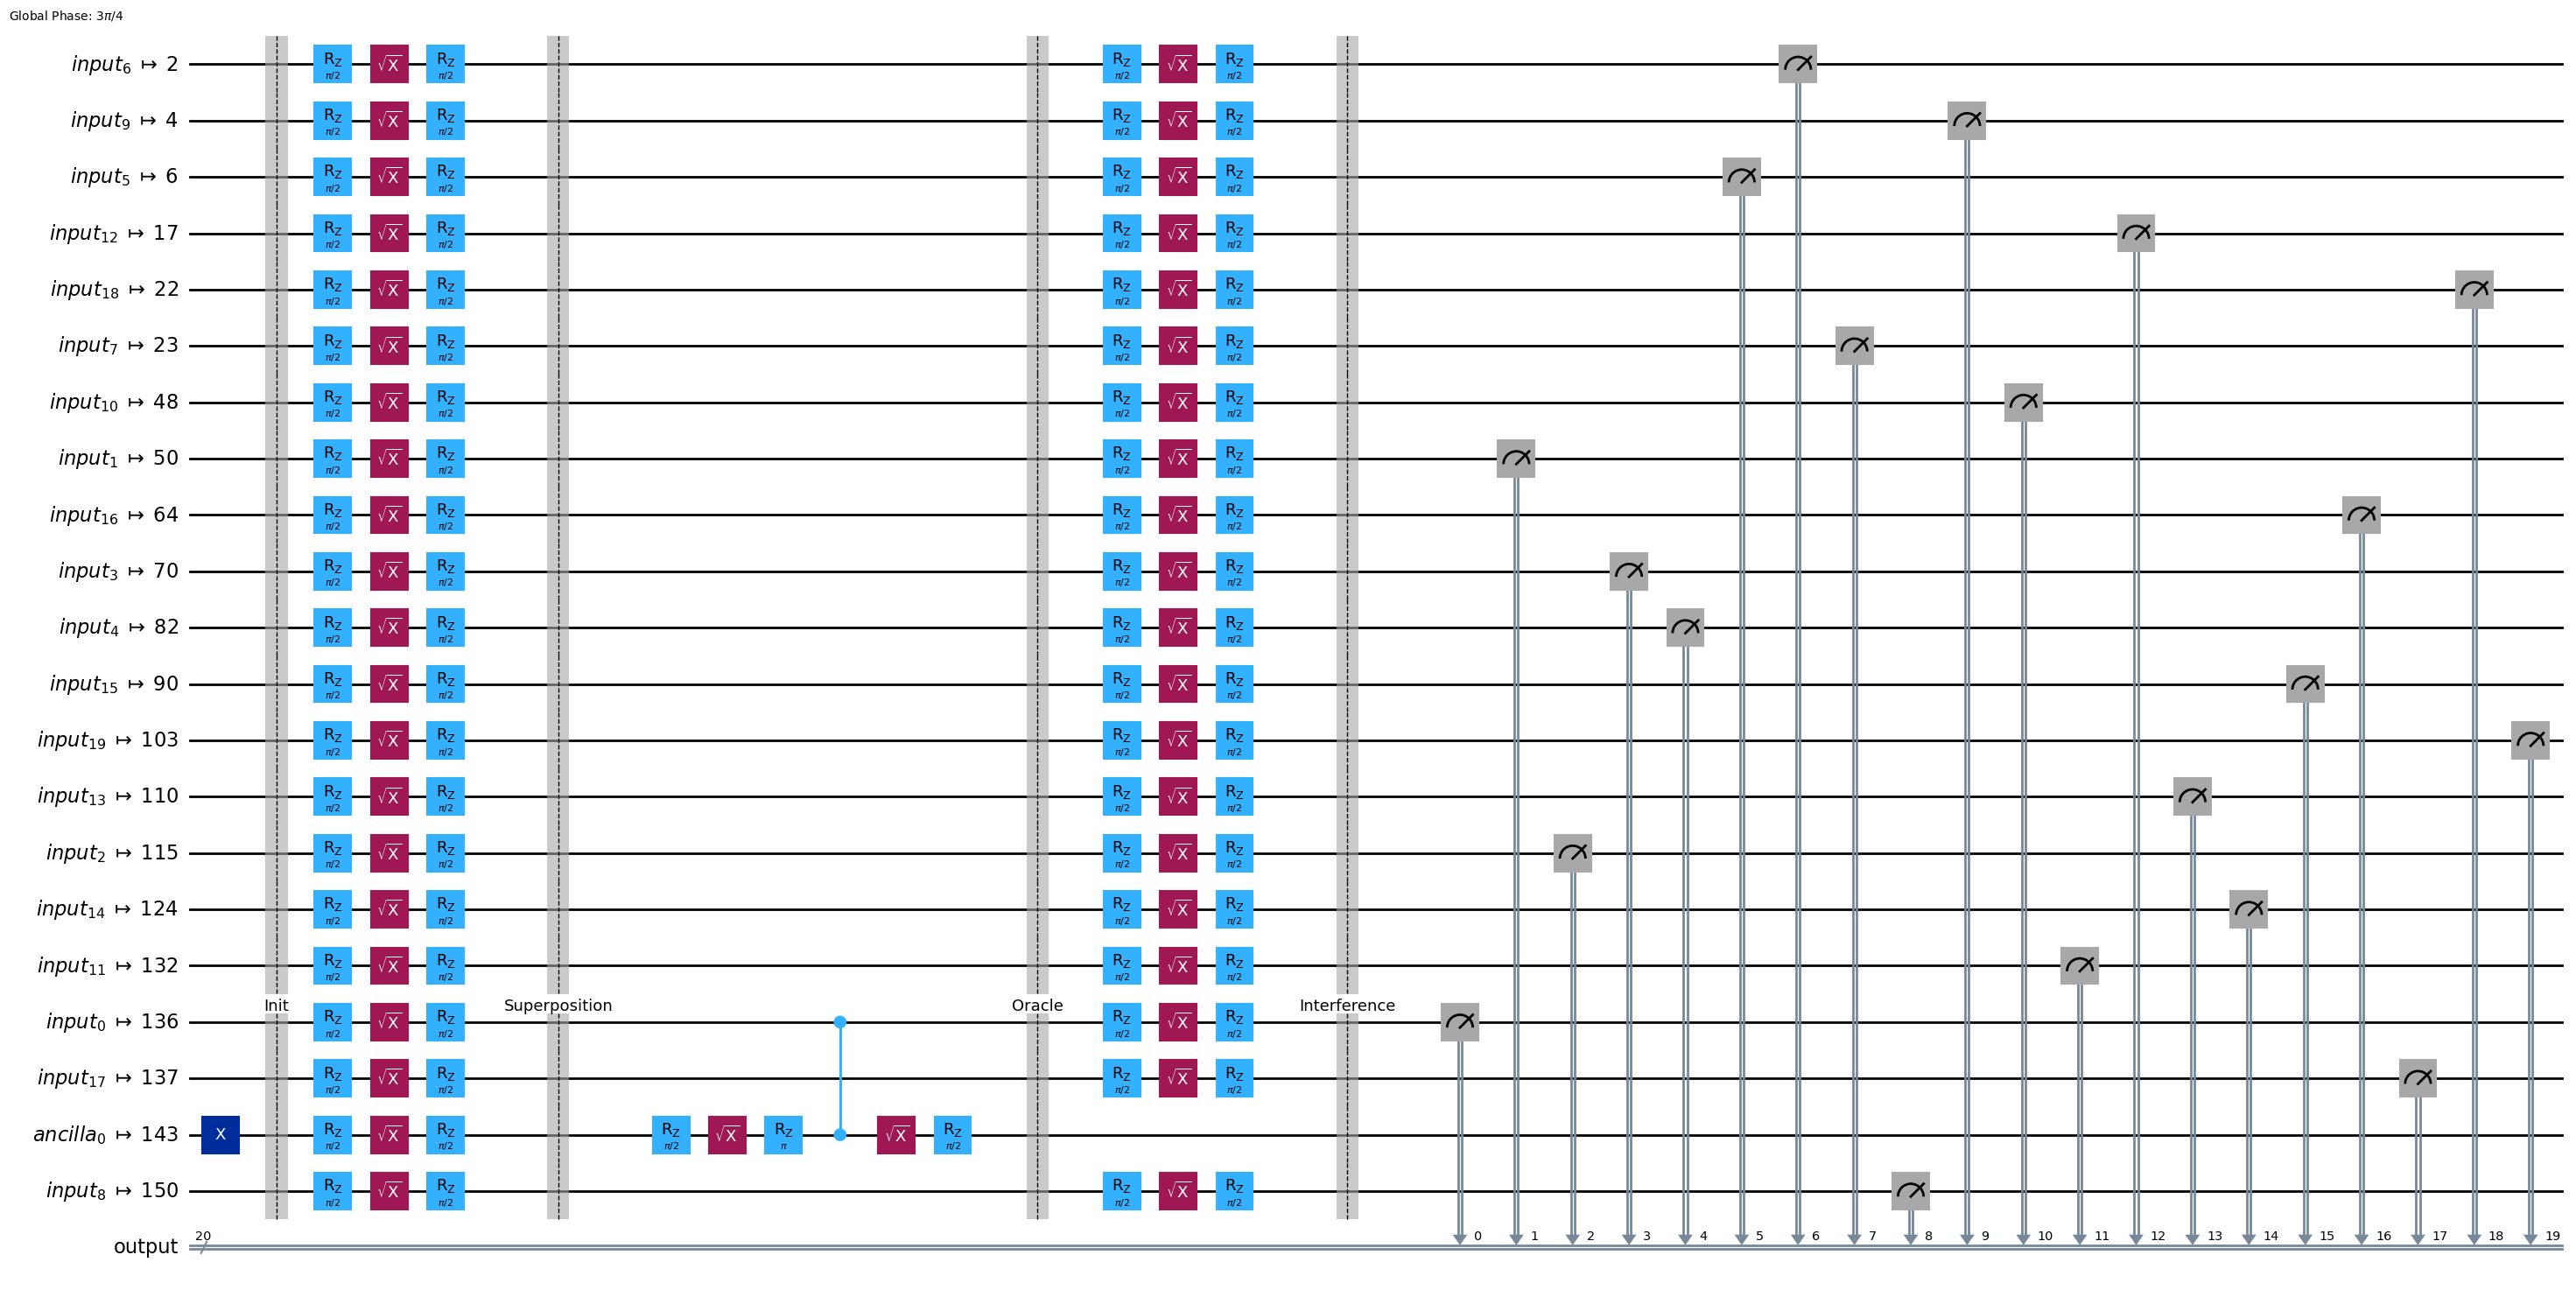

In [30]:
if backend is not None:
    # Choose which oracle to test on hardware
    test_oracle = 'balanced_1'  # Change to test different oracles
    test_circuit = circuits[test_oracle]
    
    print(f"Transpiling circuit for {backend.name}...\n")
    
    # Generate optimized pass manager for target backend
    pm = generate_preset_pass_manager(
        optimization_level=3,  # Maximum optimization
        backend=backend
    )
    
    # Transpile
    transpiled = pm.run(test_circuit)
    
    # Compare original vs transpiled
    print("Circuit Comparison:")
    print("=" * 60)
    print(f"{'Metric':<25} {'Original':>15} {'Transpiled':>15}")
    print("-" * 60)
    print(f"{'Qubits':<25} {test_circuit.num_qubits:>15} {transpiled.num_qubits:>15}")
    print(f"{'Depth':<25} {test_circuit.depth():>15} {transpiled.depth():>15}")
    print(f"{'Gate count':<25} {test_circuit.size():>15} {transpiled.size():>15}")
    print(f"{'2-qubit gates':<25} {test_circuit.num_nonlocal_gates():>15} {transpiled.num_nonlocal_gates():>15}")
    print("=" * 60)
    
    # Show transpiled gate distribution
    print("\nTranspiled gate distribution:")
    for gate, count in sorted(transpiled.count_ops().items()):
        print(f"  {gate}: {count}")
    
    # Visualize transpiled circuit (if not too large)
    if transpiled.depth() < 100:
        print("\nTranspiled Circuit:")
        display(transpiled.draw('mpl', fold=-1, idle_wires=False))
else:
    print("⚠ Skipping transpilation (no backend selected)")

#### 5.4 Job Submission and Monitoring

Submit our circuit to the quantum computer and monitor its execution.

In [31]:
if backend is not None:
    print(f"Submitting job to {backend.name}...\n")
    
    # Create Sampler with backend
    sampler = IBMSampler(backend)
    
    # Submit job
    shots = 1024
    job = sampler.run([transpiled], shots=shots)
    
    print(f"✓ Job submitted successfully!")
    print(f"  Job ID: {job.job_id()}")
    print(f"  Initial status: {job.status()}")
    print(f"  Shots requested: {shots}")
    print("\n" + "="*70)
    print("Monitoring job progress...")
    print("(This may take several minutes depending on queue)")
    print("="*70 + "\n")
    
    # Monitor job with timeout
    max_wait = 3600  # 1 hour maximum
    check_interval = 30  # Check every 30 seconds
    elapsed = 0
   

Submitting job to ibm_fez...

✓ Job submitted successfully!
  Job ID: d4nn9l9n1t7c73dhl970
  Initial status: QUEUED
  Shots requested: 1024

Monitoring job progress...
(This may take several minutes depending on queue)



In [32]:
print(job.status())

RUNNING


In [33]:
if backend is not None:
    start_time = time.time()
    
    while job.status() not in ['DONE', 'ERROR', 'CANCELLED']:
        time.sleep(check_interval)
        elapsed = int(time.time() - start_time)
        
        status = job.status()
        queue_pos = job.queue_position()
        
        # Format time
        mins, secs = divmod(elapsed, 60)
        time_str = f"{mins:02d}:{secs:02d}"
        print(status, queue_pos)
        
        print(f"[{time_str}] Status: {status.name:<12}", end="")
        if queue_pos is not None:
            print(f" | Queue position: {queue_pos}")
        else:
            print(" | Running...")
        
        if elapsed >= max_wait:
            print(f"\n⚠ Maximum wait time ({max_wait}s) exceeded!")
            print("  Job may still complete - check later using job ID")
            break
    
    # Check final status
    final_status = job.status()
    print("\n" + "="*70)
    
    if final_status == 'DONE':
        print("✓ Job completed successfully!")
        result = job.result()
        hardware_counts = result[0].data.output.get_counts()
        print(f"  Total execution time: {elapsed}s ({elapsed/60:.1f} min)")
    else:
        print(f"✗ Job ended with status: {final_status.name}")
        hardware_counts = None
        
else:
    print("⚠ Skipping hardware execution (no backend selected)")
    hardware_counts = None


✓ Job completed successfully!
  Total execution time: 0s (0.0 min)


#### 5.5 Execution Time Analysis

In [34]:
if backend is not None:
    print("⏱️  Execution Time Breakdown\n")
    print("="*70)
    
    # Get timing constraints
    config = backend.configuration()
    
    # Estimate execution time per shot
    # Rough estimate based on typical gate times
    avg_gate_time = 100e-9  # ~100 ns per gate
    circuit_execution = transpiled.depth() * avg_gate_time
    total_execution = circuit_execution * shots
    
    print(f"Circuit Execution (per shot):")
    print(f"  Gates: {transpiled.size()}")
    print(f"  Depth: {transpiled.depth()}")
    print(f"  Est. time: {circuit_execution*1e6:.1f} μs")
    print(f"\nTotal Quantum Execution:")
    print(f"  Shots: {shots}")
    print(f"  Est. time: {total_execution*1e3:.2f} ms")
    print(f"\nActual Total Time: {elapsed}s ({elapsed/60:.1f} min)")
    print(f"  Includes: Queue time + Circuit execution + Data transfer")
    
    # IBM Quantum free tier info
    print("\n" + "="*70)
    print("💡 IBM Quantum Free Tier Information:")
    print("  • 10 minutes of quantum computing time per month")
    print(f"  • This job used: ~{total_execution:.4f}s of quantum time")
    print(f"  • Remaining approx: ~{600-total_execution:.1f}s this month")
    print("  • Queue time does NOT count against your quota")
    print("="*70)
else:
    print("⚠ Skipping time analysis (no hardware execution)")

⏱️  Execution Time Breakdown

Circuit Execution (per shot):
  Gates: 150
  Depth: 14
  Est. time: 1.4 μs

Total Quantum Execution:
  Shots: 1024
  Est. time: 1.43 ms

Actual Total Time: 0s (0.0 min)
  Includes: Queue time + Circuit execution + Data transfer

💡 IBM Quantum Free Tier Information:
  • 10 minutes of quantum computing time per month
  • This job used: ~0.0014s of quantum time
  • Remaining approx: ~600.0s this month
  • Queue time does NOT count against your quota


## 📊 Results Analysis

Compare simulation results with hardware results to understand quantum noise effects.

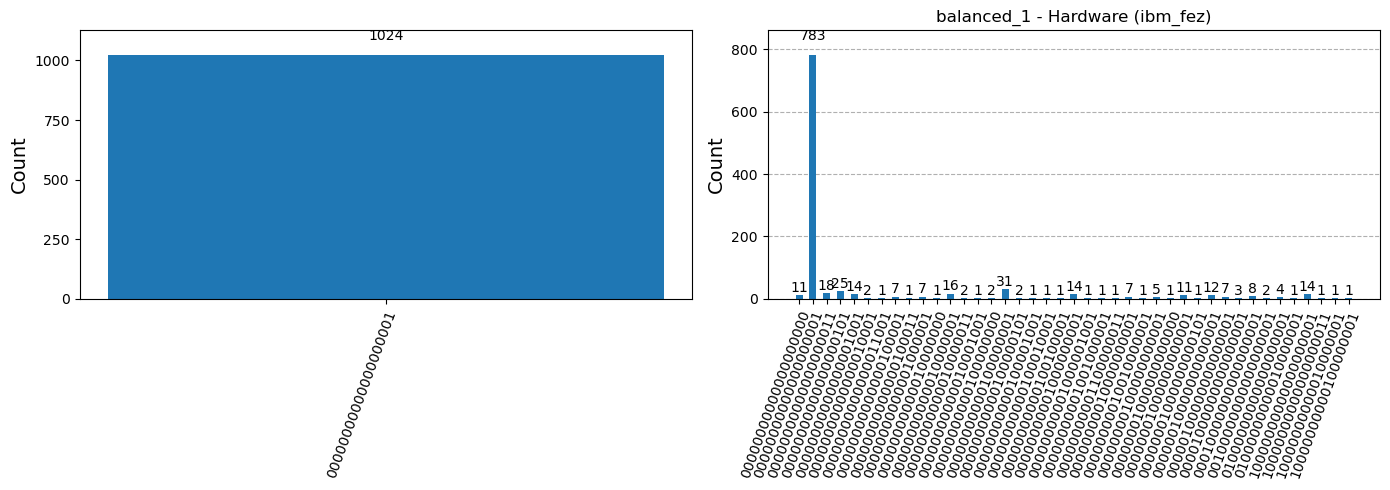


RESULTS ANALYSIS

Probability of measuring |000...0⟩:
  Simulation: 0.000
  Hardware:   0.011

Expected: BALANCED (should NOT measure |000...0⟩)
✓ Hardware correctly identifies as BALANCED

Hellinger Fidelity: 0.7646
  (1.0 = perfect match, 0.0 = completely different)
  ✓ Good agreement (typical for NISQ devices)

💡 Key Observations:
  • Hardware results show noise effects (decoherence, gate errors)
  • Correct answer still usually visible in measurements
  • Error mitigation techniques can improve results
  • Deeper circuits are more affected by noise (NISQ era)


In [35]:
if hardware_counts is not None:
    # Visualize comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Simulation results
    plot_histogram(sim_results[test_oracle], ax=ax1, 
                   title=f"{test_oracle} - Simulation (Ideal)")
    
    # Hardware results
    plot_histogram(hardware_counts, ax=ax2,
                   title=f"{test_oracle} - Hardware ({backend.name})")
    
    plt.tight_layout()
    plt.show()
    
    # Analyze results
    print("\n" + "="*70)
    print("RESULTS ANALYSIS")
    print("="*70)
    
    # Check if we measure all zeros
    all_zeros = '0' * n
    
    sim_zeros_prob = sim_results[test_oracle].get(all_zeros, 0) / 1024
    hw_zeros_prob = hardware_counts.get(all_zeros, 0) / shots
    
    print(f"\nProbability of measuring |000...0⟩:")
    print(f"  Simulation: {sim_zeros_prob:.3f}")
    print(f"  Hardware:   {hw_zeros_prob:.3f}")
    
    # Interpretation
    expected_type = "CONSTANT" if 'constant' in test_oracle else "BALANCED"
    
    if expected_type == "CONSTANT":
        print(f"\nExpected: CONSTANT (should measure ~100% |000...0⟩)")
        if hw_zeros_prob > 0.8:
            print("✓ Hardware correctly identifies as CONSTANT")
        else:
            print("⚠ Hardware result affected by noise")
    else:
        print(f"\nExpected: BALANCED (should NOT measure |000...0⟩)")
        if hw_zeros_prob < 0.2:
            print("✓ Hardware correctly identifies as BALANCED")
        else:
            print("⚠ Hardware result affected by noise")
    
    # Calculate fidelity
    from qiskit.quantum_info import hellinger_fidelity
    
    fidelity = hellinger_fidelity(sim_results[test_oracle], hardware_counts)
    print(f"\nHellinger Fidelity: {fidelity:.4f}")
    print("  (1.0 = perfect match, 0.0 = completely different)")
    
    if fidelity > 0.9:
        print("  ✓ Excellent agreement with simulation")
    elif fidelity > 0.7:
        print("  ✓ Good agreement (typical for NISQ devices)")
    else:
        print("  ⚠ Significant noise effects observed")
    
    print("\n" + "="*70)
    print("💡 Key Observations:")
    print("  • Hardware results show noise effects (decoherence, gate errors)")
    print("  • Correct answer still usually visible in measurements")
    print("  • Error mitigation techniques can improve results")
    print("  • Deeper circuits are more affected by noise (NISQ era)")
    print("="*70)
    
else:
    print("⚠ No hardware results to analyze")
    print("  Run the hardware execution cells above to compare results")

## ⚡ Complexity Comparison

Let's visualize why the Deutsch-Jozsa algorithm demonstrates quantum advantage.

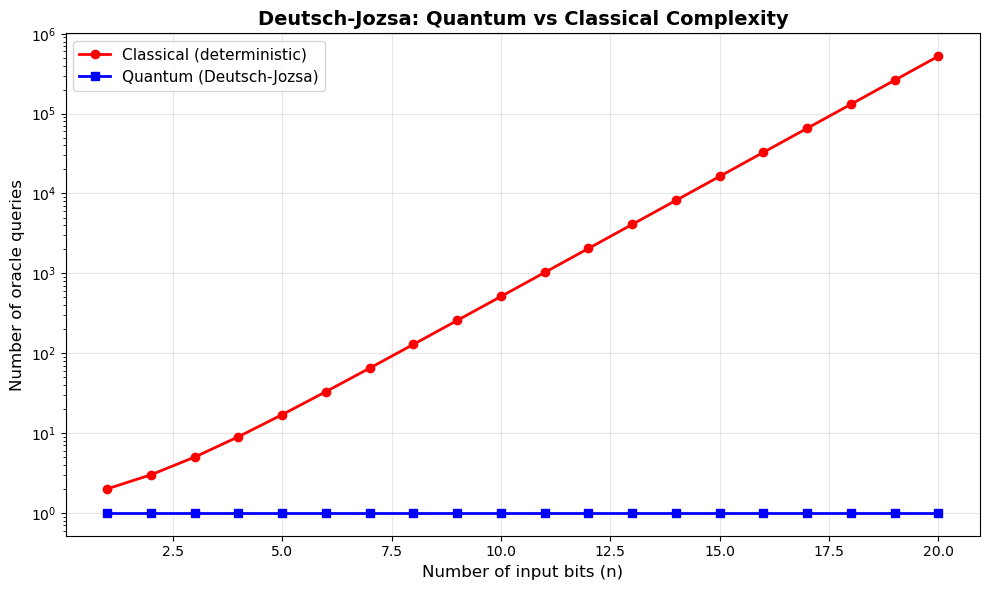


📈 Complexity Analysis:
n     Classical Queries    Quantum Queries      Speedup        
----------------------------------------------------------------------
3     5                    1                    5x
5     17                   1                    17x
10    513                  1                    513x
15    16,385               1                    16,385x
20    524,289              1                    524,289x

💡 Key Insight:
  The quantum speedup is EXPONENTIAL!
  For n=20 bits, quantum is ~500,000x faster!
  This demonstrates quantum supremacy for this specific problem.


In [36]:
# Compare classical vs quantum complexity
n_values = np.arange(1, 21)
classical_queries = 2**(n_values-1) + 1  # Deterministic worst case
quantum_queries = np.ones_like(n_values)  # Always 1 query

plt.figure(figsize=(10, 6))
plt.semilogy(n_values, classical_queries, 'r-o', label='Classical (deterministic)', linewidth=2)
plt.semilogy(n_values, quantum_queries, 'b-s', label='Quantum (Deutsch-Jozsa)', linewidth=2)
plt.xlabel('Number of input bits (n)', fontsize=12)
plt.ylabel('Number of oracle queries', fontsize=12)
plt.title('Deutsch-Jozsa: Quantum vs Classical Complexity', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\n📈 Complexity Analysis:")
print("="*70)
print(f"{'n':<5} {'Classical Queries':<20} {'Quantum Queries':<20} {'Speedup':<15}")
print("-"*70)
for n_val in [3, 5, 10, 15, 20]:
    classical = 2**(n_val-1) + 1
    quantum = 1
    speedup = classical / quantum
    print(f"{n_val:<5} {classical:<20,} {quantum:<20} {speedup:,.0f}x")

print("="*70)
print("\n💡 Key Insight:")
print("  The quantum speedup is EXPONENTIAL!")
print("  For n=20 bits, quantum is ~500,000x faster!")
print("  This demonstrates quantum supremacy for this specific problem.")

## 🎓 Exercises

Test your understanding with these challenges!

### Exercise 1: Custom Oracle (Easy)

Create a new balanced oracle that implements:
$$f(x) = x_0 \oplus x_1 \oplus x_2$$

**Hint**: Use multiple CNOT gates.

In [ ]:
# Your solution here
def create_custom_oracle(n_qubits: int) -> QuantumCircuit:
    """
    Create oracle for f(x) = x_0 XOR x_1 XOR x_2
    """
    oracle = QuantumCircuit(n_qubits + 1, name="Custom_Oracle")
    
    # TODO: Add your gates here
    
    return oracle

# Test your oracle
# custom_circuit = deutsch_jozsa_circuit_with_custom_oracle(3)
# counts = run_simulation(custom_circuit)
# plot_histogram(counts)

### Exercise 2: Partial Deutsch-Jozsa (Medium)

Modify the algorithm to work with a function that is neither perfectly balanced nor constant,
but instead outputs 1 for 3/4 of inputs and 0 for 1/4 of inputs.

**Question**: What do you expect to measure? Why does the original algorithm fail here?

In [ ]:
# Your solution here

### Exercise 3: Noise Analysis (Hard)

Run the same circuit on multiple IBM Quantum backends and compare:
1. Fidelity with ideal simulation
2. Success rate in identifying constant vs balanced
3. Error patterns in measurements

**Bonus**: Plot how fidelity decreases with circuit depth.

In [ ]:
# Your solution here

## 📖 References

### Academic Papers

1. **Original Paper**:  
   Deutsch, D., & Jozsa, R. (1992). *Rapid solution of problems by quantum computation*.  
   Proceedings of the Royal Society of London A, 439(1907), 553-558.
   
2. **Improved Algorithm**:  
   Cleve, R., Ekert, A., Macchiavello, C., & Mosca, M. (1998).  
   *Quantum algorithms revisited*. Proceedings of the Royal Society A, 454(1969), 339-354.

### Online Resources

- [Qiskit Textbook - Deutsch-Jozsa](https://learn.qiskit.org/course/ch-algorithms/deutsch-jozsa-algorithm)
- [IBM Quantum Documentation](https://docs.quantum.ibm.com/)
- [Qiskit 2.2 Migration Guide](https://docs.quantum.ibm.com/migration-guides)

### Related Algorithms

- Deutsch Algorithm (special case: n=1)
- Bernstein-Vazirani Algorithm (extension)
- Simon's Algorithm (similar oracle-based approach)

---

**Author**: Quantum Computing Course  
**License**: MIT  
**Version**: 2.2.0 (Qiskit 2.2 Compatible)  
**Last Updated**: November 2025